In [1]:
from matplotlib import pyplot as plt

import torch as tc
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision as tv
from torchvision import transforms
from torchvision import datasets as d
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from scipy.signal import fftconvolve
from numpy.fft import ifftshift, fftshift, fft2, ifft2


device = tc.device('cuda:0')

# データは num = 0の画像のみ
transform = transforms.Compose([transforms.ToTensor()])
whole_trainset = d.MNIST(root='./data', train=True, download=True, transform=transform)
train_mask = (whole_trainset.targets == 0).nonzero()[:, 0]
trainset = Subset(whole_trainset, train_mask)

whole_testset = d.MNIST(root='./data', train=False, download=True, transform=transform)
test_mask  = (whole_testset.targets == 0).nonzero()[:, 0]
testset = Subset(whole_testset, test_mask)
trainloader = DataLoader(trainset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

In [79]:
import numpy as np
from scipy.stats import multivariate_normal

# 準備するフィルタのサイズを5x5に固定
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
sigma = 1.3
filter_stds = [sigma * i for i in range(1, 6)]
kernels = []
for std in filter_stds:
    f = np.vectorize(
        lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y])
    )
    kernel = f(X, Y)
    kernel = kernel / kernel.sum()
    kernels.append(kernel)

(28, 28)


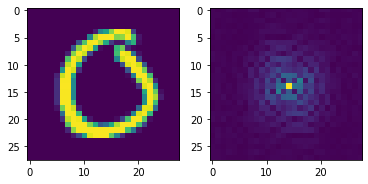

In [3]:
# 離散フィルタのフーリエ変換について考えてみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
print(img.shape)

plt.subplot(1,2,1)
plt.imshow(img)

fft_img = fftshift(fft2(img))
plt.subplot(1,2,2)
plt.imshow(np.abs(fft_img))
plt.show()

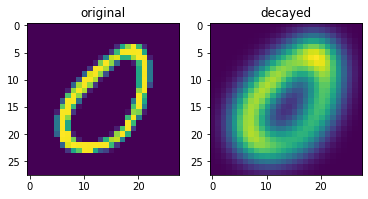

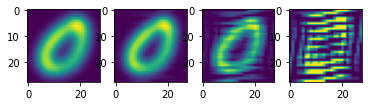

42.7239966652574
False
156.2919623320547


In [63]:
from skimage.restoration import wiener
# 離散フィルタのフーリエ変換について考えてみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
decayed = img.copy()

kernel = kernels[0]

plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(img)

def loss(x, source):
    return np.sum((x - source)**2)

for _ in range(5):
    decayed = fftconvolve(decayed, kernel, mode='same')
plt.subplot(1, 2, 2)
plt.title('decayed')
plt.imshow(decayed)
plt.show()

restored = decayed
restore_path = [restored]
for _ in range(3):
    restored = np.maximum(0.0, wiener(restored, kernel, 1e-4))
    restore_path.append(restored)
    
for i, restore in enumerate(restore_path, start=1):
    plt.subplot(1, 4, i)
    plt.imshow(restore)
plt.show()

print(loss(decayed, img))
print(np.allclose(restored, img))
print(loss(restored, img))

In [160]:
from itertools import permutations

import numpy as np
from scipy.stats import multivariate_normal

n = 3
np.random.seed(0)

# 準備するフィルタのサイズを5x5に固定
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
sigma = 0.3
filter_stds = [sigma * i for i in range(1, n + 1)]
kernels = []
for std in filter_stds:
    f = np.vectorize(
        lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y])
    )
    kernel = f(X, Y)
    kernel = kernel / kernel.sum()
    kernels.append(kernel)

decayed = img
for kernel in kernels:
    decayed = fftconvolve(imgs[-1], kernel, mode='same')

3


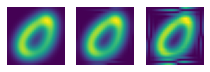

41.97534719896858


In [164]:
restored = decayed
restore_path = []
for kernel in kernels:
    restored = np.maximum(0.0, wiener(restored, kernel, 1e-4))
    restore_path.append(restored)
    
print(len(restore_path))
for i in range(3):
    plt.subplot(1, 5, i + 1)
    plt.imshow(restore_path[i])
    plt.axis('off')
plt.show()
print(loss(restored, img))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1)]
41.65280386172827


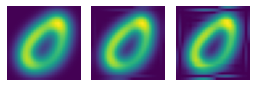

41.671778173670425


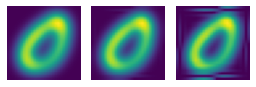

41.94420478623198


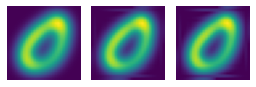

41.94446540262191


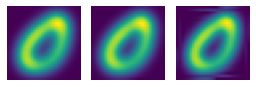

41.97534719896858


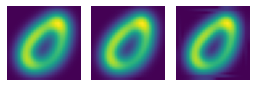

In [163]:
row = []
samples = []
for kernel_set in permutations(range(n), 3):
    samples.append(kernel_set)
    col = [decayed]
    for j in kernel_set:
        col.append(
            np.maximum(0.0, wiener(col[-1], kernels[j], 1e-4))
        )
    row.append(col)

print(samples[:5])
# 上位5件を出力
row = sorted(row, key=lambda r: min(loss(c, img) for c in r))
for i in range(5):
    print(min(loss(c, img) for c in row[i]))
    for j in range(3):
        plt.subplot(1, 5, j+1)
        plt.imshow(row[i][j])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

kernel sigma = 1.3
復元前 誤差: 15.543681455747556
復元後 誤差: 27.630460694212154



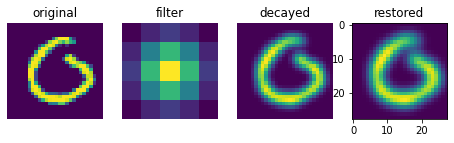

kernel sigma = 2.6
復元前 誤差: 22.408775728435188
復元後 誤差: 34.97526124074152



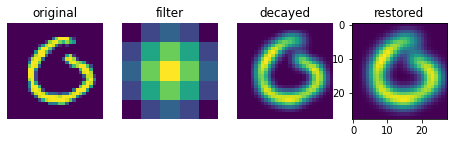

kernel sigma = 3.9
復元前 誤差: 25.242173041324193
復元後 誤差: 37.43763080019553



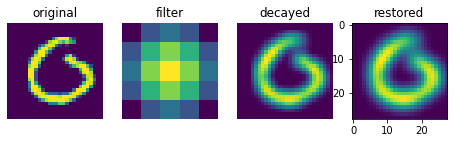

In [58]:
# ガウスフィルタを畳み込んだ結果を見てみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
# img = tc.tensor(np.pad(img, pad_width=28))

display_num = 6
for i, kernel in enumerate(kernels, start=1):
    plt.figure(figsize=(12, 6.4))
    plt.subplot(1, display_num, 1)
    plt.title('original')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, display_num, 2)
    plt.title('filter')
    plt.imshow(kernel)
    plt.axis('off')

    plt.subplot(1, display_num, 3)
    plt.title('decayed')
    decayed = fftconvolve(img, kernel, mode='same')
    plt.imshow(decayed)
    plt.axis('off')

    plt.subplot(1, display_num, 4)
    plt.title('restored')
    inverse_kernel = kernel[::-1, ::-1]
    restored = fftconvolve(decayed, inverse_kernel, mode='same')
    plt.imshow(restored)
    print(f'kernel sigma = {sigma * i:.1f}')
    print('復元前 誤差:', np.sum((decayed - img)**2))
    print('復元後 誤差:', np.sum((restored - img)**2))
    print()
    plt.show()

kernel sigma = 1.3
復元前 誤差: 12.060547933318134
復元後 誤差: 0.12271004396055582



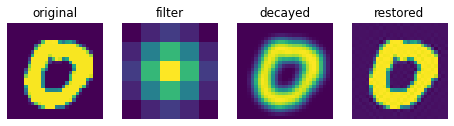

kernel sigma = 2.6
復元前 誤差: 16.73875614858651
復元後 誤差: 0.04595327091051038



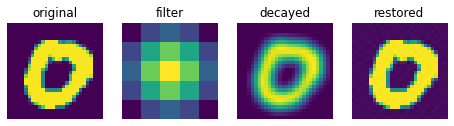

kernel sigma = 3.9
復元前 誤差: 18.68052570423441
復元後 誤差: 0.004196450925760389



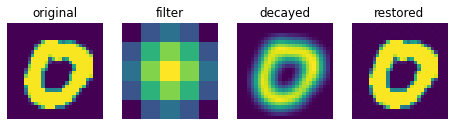

In [16]:
from skimage.restoration import wiener
# ガウスフィルタを畳み込んだ結果を見てみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
# img = tc.tensor(np.pad(img, pad_width=28))

display_num = 6
for i, kernel in enumerate(kernels, start=1):
    plt.figure(figsize=(12, 6.4))
    plt.subplot(1, display_num, 1)
    plt.title('original')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, display_num, 2)
    plt.title('filter')
    plt.imshow(kernel)
    plt.axis('off')

    plt.subplot(1, display_num, 3)
    plt.title('decayed')
    decayed = fftconvolve(img, kernel, mode='same')
    plt.imshow(decayed)
    plt.axis('off')

    plt.subplot(1, display_num, 4)
    plt.title('restored')
    restored = wiener(decayed, kernel, 1e-8)
#     restored = fftconvolve(decayed, inverse_kernel, mode='same')
    plt.imshow(restored)
    plt.axis('off')
    
    print(f'kernel sigma = {sigma * i:.1f}')
    print('復元前 誤差:', np.sum((decayed - img)**2))
    print('復元後 誤差:', np.sum((restored - img)**2))
    print()
    plt.show()

kernel sigma = 0.3
復元前 誤差: 3.1546066006901556
復元後 誤差: 1215.374175705699



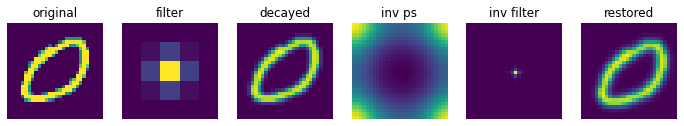

kernel sigma = 0.6
復元前 誤差: 9.395950526946406
復元後 誤差: 360610.063027252



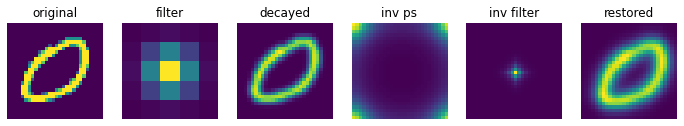

kernel sigma = 0.9
復元前 誤差: 14.279637708121063
復元後 誤差: 49790530.015557796



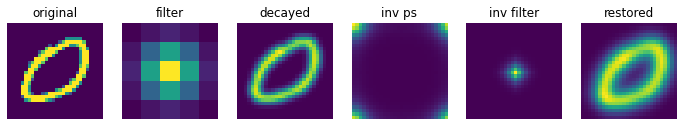

In [10]:
# ガウスフィルタを畳み込んだ結果を見てみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
# img = tc.tensor(np.pad(img, pad_width=28))

display_num = 6
for i, kernel in enumerate(kernels, start=1):
    plt.figure(figsize=(12, 6.4))
    plt.subplot(1, display_num, 1)
    plt.title('original')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, display_num, 2)
    plt.title('filter')
    plt.imshow(kernel)
    plt.axis('off')

    plt.subplot(1, display_num, 3)
    plt.title('decayed')
    decayed = fftconvolve(img, kernel, mode='same')
    plt.imshow(decayed)
    plt.axis('off')

    plt.subplot(1, display_num, display_num-2)
    plt.title('inv ps')
    fft_val = fftshift(fft2(img)/fft2(decayed))
    plt.imshow(np.abs(fft_val))
    plt.axis('off')
    
    plt.subplot(1, display_num, display_num-1)
    plt.title('inv filter')
    inverse_kernel = np.abs(ifftshift(ifft2(fft_val)))
    plt.imshow(inverse_kernel)
    plt.axis('off')
    
    plt.subplot(1, display_num, display_num)
    plt.title('restored')
    restored = fftconvolve(decayed, inverse_kernel, mode='same')
    plt.imshow(restored)
    plt.axis('off')
    
    print(f'kernel sigma = {sigma * i:.1f}')
    print('復元前 誤差:', np.sum((decayed - img)**2))
    print('復元後 誤差:', np.sum((restored - img)**2))
    print()
    plt.show()

kernel sigma = 1.3
復元前 誤差: 15.916571387604549
復元後 誤差: 4370144899.795174



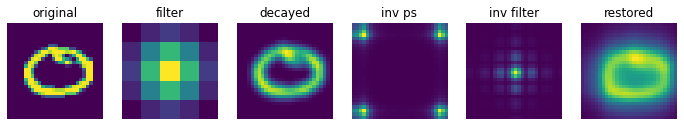

kernel sigma = 2.6
復元前 誤差: 25.21840322804021
復元後 誤差: 121250585.83075568



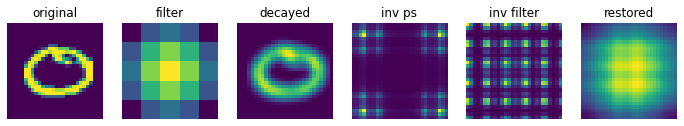

kernel sigma = 3.9
復元前 誤差: 27.540424019404128
復元後 誤差: 304125246.8709421



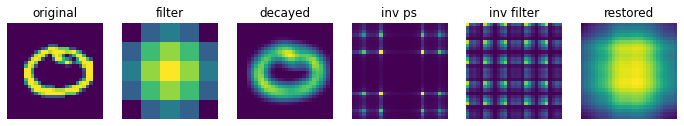

In [36]:
# ガウスフィルタを畳み込んだ結果を見てみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
# img = tc.tensor(np.pad(img, pad_width=28))

display_num = 6
for i, kernel in enumerate(kernels, start=1):
    plt.figure(figsize=(12, 6.4))
    plt.subplot(1, display_num, 1)
    plt.title('original')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, display_num, 2)
    plt.title('filter')
    plt.imshow(kernel)
    plt.axis('off')

    plt.subplot(1, display_num, 3)
    plt.title('decayed')
    decayed = fftconvolve(img, kernel, mode='same')
    plt.imshow(decayed)
    plt.axis('off')

    plt.subplot(1, display_num, display_num - 2)
    plt.title('inv ps')
    fft_val = fftshift(fft2(img)/fft2(decayed))
    plt.imshow(np.abs(fft_val))
    plt.axis('off')
    
    plt.subplot(1, display_num, display_num - 1)
    plt.title('inv filter')
    inverse_kernel = np.abs(ifftshift(ifft2(fft_val)))
    plt.imshow(inverse_kernel)
    plt.axis('off')
    
    plt.subplot(1, display_num, display_num)
    plt.title('restored')
    restored = fftconvolve(decayed, inverse_kernel, mode='same')
    plt.imshow(restored)
    plt.axis('off')
    
    print(f'kernel sigma = {1.3 * i:.1f}')
    print('復元前 誤差:', np.sum((decayed - img)**2))
    print('復元後 誤差:', np.sum((restored - img)**2))
    print()
    plt.show()

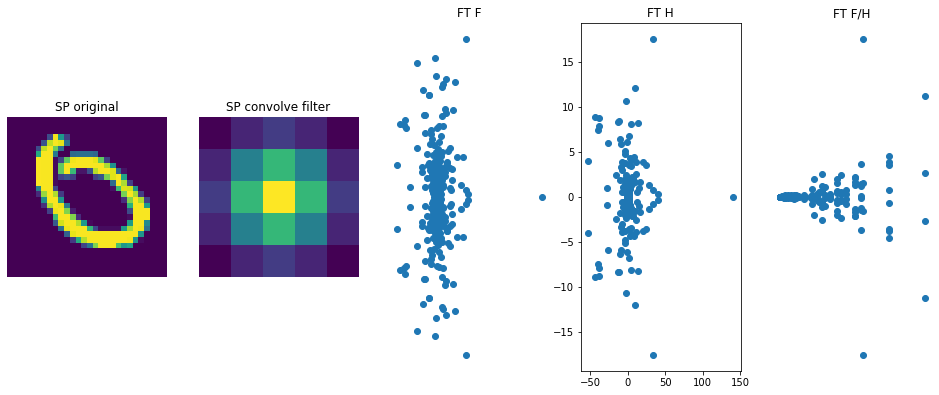

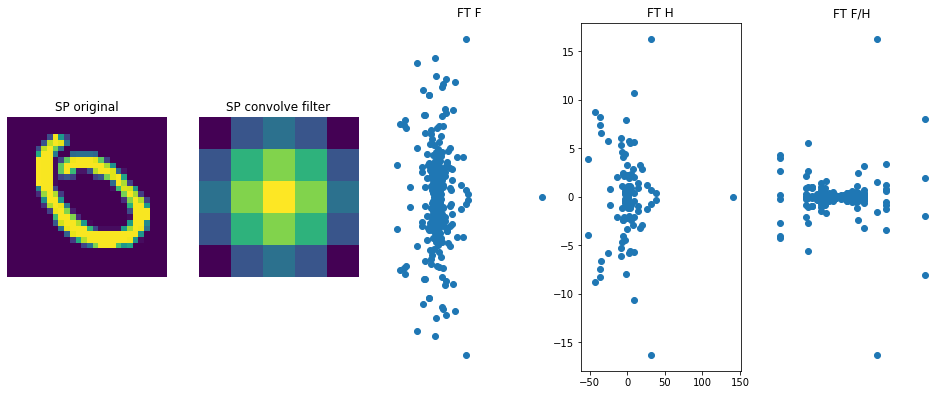

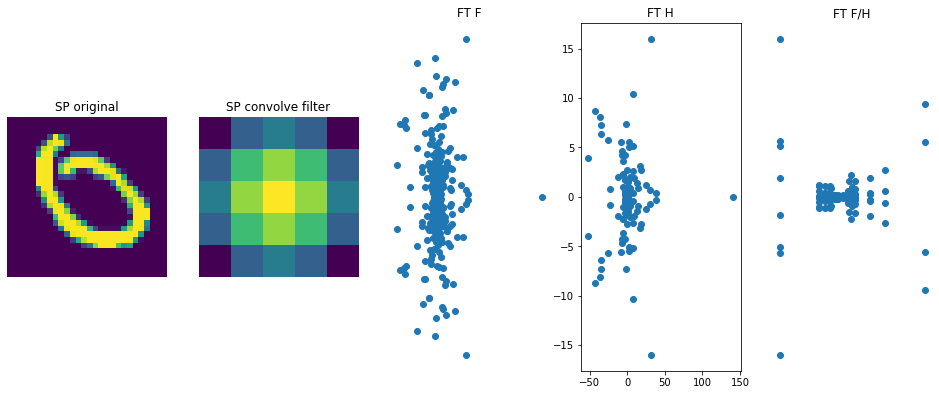

In [32]:
# ガウスフィルタを畳み込んだ結果を見てみる
data = iter(trainloader)
img, _ = next(data)
img = img[0][0].numpy()
# img = tc.tensor(np.pad(img, pad_width=28))

display_num = 6
for i, kernel in enumerate(kernels, start=1):
    plt.figure(figsize=(20, 6.4))
    plt.subplot(1, display_num, 1)
    plt.title('SP original')
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, display_num, 2)
    plt.title('SP convolve filter')
    plt.imshow(kernel)
    plt.axis('off')
    
    plt.subplot(1, display_num, 3)
    F = fft2(img)
    plt.title('FT F')
    plt.scatter(F.real, F.imag)
    plt.axis('off')
    
    plt.subplot(1, display_num, 4)
    decayed = fftconvolve(img, kernel, mode='same')
    H = fft2(decayed)
    plt.title('FT H')
    plt.scatter(H.real, H.imag)
        
    plt.subplot(1, display_num, 5)
    Q = fft2(img) / fft2(decayed)
    plt.title('FT F/H')
    plt.scatter(Q.real, Q.imag)
    plt.axis('off')